In [1]:
import datetime as dt
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이전 실습과 다른 부분은 SessionID대신 UserID항목이 들어갔다.
    - 명확한 1회 세션의 SessionID를 포함하지 않고 있다.
    - 이번에는 UserID가 SessionID역하을 해야 한다.
- Rating정보가 포함되어 있다.
    - 직전에 봣던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다.
    - Rating이 낮은 데이터를 어떻게 저리할지도 고민해야 한다.
- Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## Step 1. 데이터의 전처리
- 항목별 기본분석
- Session length, Session time, cleaning 등의 작업을 진행
- Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.

## Step 2. 미니 배치의 구성
- Session-Parallel Mine-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
- step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch가 굳이 필요하지 않을 수도 있다.

## Step 3. 모델 구성
- 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있다.

## Step 4. 모델 학습
- 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 한다.
- 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 한다.

## Step 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR을 확인

# 1. Data 전처리
---
- 데이터 정보
    ![image](https://user-images.githubusercontent.com/48716219/98061866-36e47d80-1e90-11eb-9d99-c7dfac8bb4bb.png)


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

각 사용자 별로 보통 96 ~ 165 정도..
- 사용자가 리뷰를 남기는 횟수를 의미
- 일반적으로 96~165개의 영화 리뷰를 남긴다

In [5]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

99.9%의 사용자는 1343개의 리뷰를 남긴다..  
최소 20개의 리뷰, 최대 2314개의 리뷰를 남김

In [6]:
user_length.quantile(0.999)

1343.181000000005

In [7]:
user_length.min(), user_length.max()

(20, 2314)

user_length를 boxplot으로 그려본다

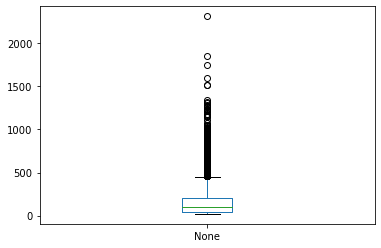

In [8]:
user_length.plot.box()
plt.show()

## 2314개의 리뷰를 남긴 데이터를 확인해본다

In [9]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [10]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = user_length.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

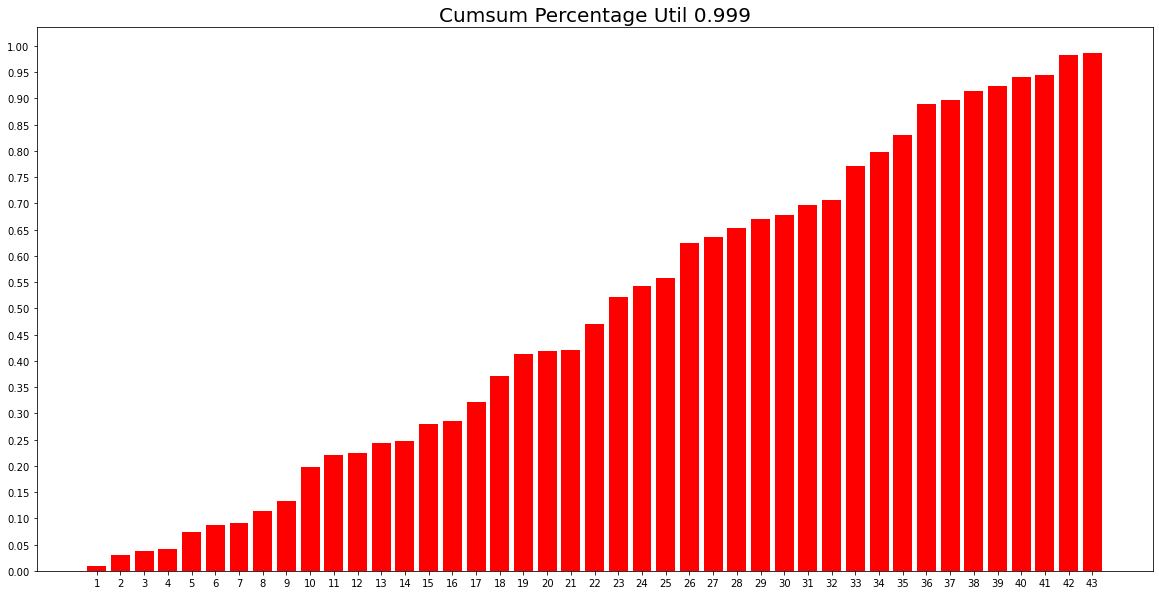

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title("Cumsum Percentage Util 0.999", size=20)
plt.show()

In [12]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

#### ```datetime.timedelta``` 활용하기
- ```datetime.timedelta()```에서 ```seconds```인자를 활용해서 1970년 01월 01년 기준으로 언제 작성한 리뷰인지 새로운 칼럼 ```Datetime```을 생성한다
  
```python
import datetime as dt

datetime.timedelta(seconds=978300019)
>>> datetime.timedelta(days=11322, seconds=79219)

data.Datetime[0]
>>> Timestamp('1970-01-01 00:00:00.019700101')

data.Datetime[0] + datetime.timedelta(seconds=978300019)
>>> Timestamp('2000-12-31 22:00:19.019700101')
```

In [13]:
data['Datetime'] = '1970-01-01 00:00:00'
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.dtypes

UserId               int32
ItemId               int32
Rating               int32
Time                 int64
Datetime    datetime64[ns]
dtype: object

In [14]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,1970-01-01
22,1,1270,5,978300055,1970-01-01
27,1,1721,4,978300055,1970-01-01
37,1,1022,5,978300055,1970-01-01
24,1,2340,3,978300103,1970-01-01
...,...,...,...,...,...
1000019,6040,2917,4,997454429,1970-01-01
999988,6040,1921,4,997454464,1970-01-01
1000172,6040,1784,3,997454464,1970-01-01
1000167,6040,161,3,997454486,1970-01-01


In [15]:
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


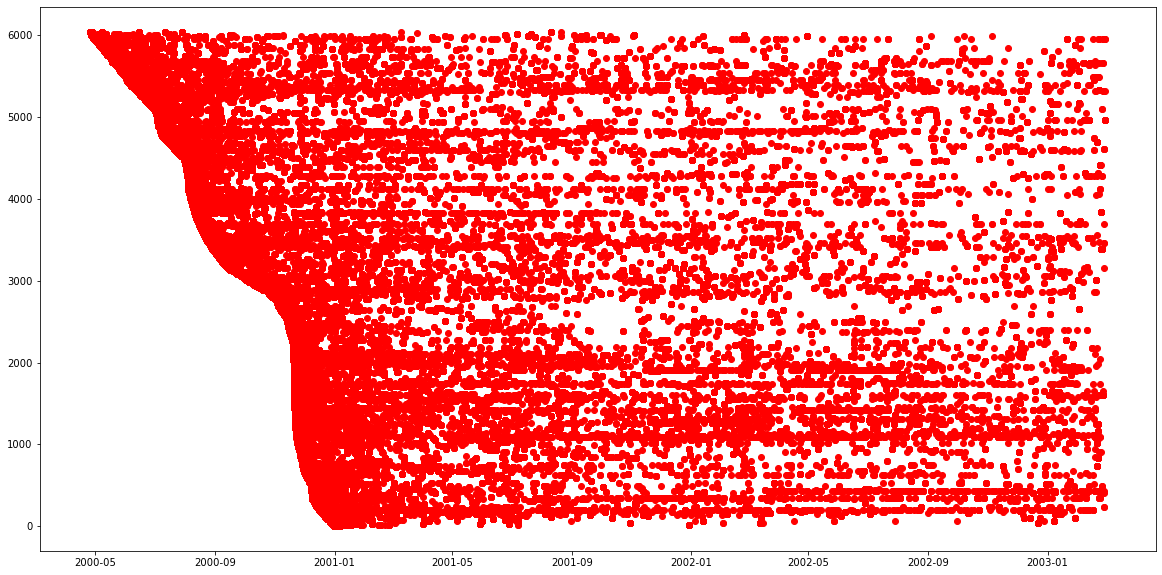

In [16]:
plt.figure(figsize=(20, 10))
plt.scatter(x=data.Datetime,
           y=data.UserId,
           color='red')
# plt.xticks(data.Datetime.values, fontsize=15)
# data.plot(kind='scatter', x='Datetime', y='UserId', color='blue')
plt.show()

# train/valid/test split
---
- 한달치의 데이터만 사용하기에는 데이터가 너무 적다(1551개)
- 3년치 데이터를 모두 활용 (1038일)
    - train : 933일
    - valid : 90일
    - test : 15일

In [17]:
origin_data = data.copy()

In [18]:
data['Datetime'].max() - data['Datetime'].min()

Timedelta('1038 days 18:44:18')

In [19]:
latest = data['Datetime'].max()

In [20]:
test_days = latest - dt.timedelta(15)
test_days

Timestamp('2003-02-13 17:49:50')

In [21]:
valid_days = test_days - dt.timedelta(90)
valid_days

Timestamp('2002-11-15 17:49:50')

In [22]:
train_data = data[data['Datetime'] <= valid_days]
test_data = data[data['Datetime'] > test_days]

temp_data = data[data['Datetime'] <= test_days]
valid_data = temp_data[temp_data['Datetime'] > valid_days]

In [23]:
train_data['Datetime'].min(), train_data['Datetime'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2002-11-15 16:08:13'))

In [24]:
valid_data['Datetime'].min(), valid_data['Datetime'].max()

(Timestamp('2002-11-15 20:19:05'), Timestamp('2003-02-13 16:36:54'))

In [25]:
test_data['Datetime'].min(), test_data['Datetime'].max()

(Timestamp('2003-02-13 18:06:30'), Timestamp('2003-02-28 17:49:50'))

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [27]:
stats_info(train_data, 'train')
stats_info(valid_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 994758
	 Sessions: 6039
	 Items: 3706
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-11-15 16:08:13

* valid Set Stats Info
	 Events: 4794
	 Sessions: 243
	 Items: 1820
	 First Time : 2002-11-15 20:19:05
	 Last Time : 2003-02-13 16:36:54

* test Set Stats Info
	 Events: 657
	 Sessions: 68
	 Items: 538
	 First Time : 2003-02-13 18:06:30
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_data.to_pickle(save_path / 'train.pkl')
valid_data.to_pickle(save_path / 'valid.pkl')
test_data.to_pickle(save_path / 'test.pkl')

In [30]:
val = np.zeros(valid_data['UserId'].nunique() + 1, dtype=np.int32)
val[1:] = valid_data.groupby('UserId').size().cumsum()

In [31]:
tt = origin_data.copy()
tt

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [32]:
tt.drop('Rating', axis=1, inplace=True)
tt.drop('Time', axis=1, inplace=True)
tt

,UserId,ItemId,Datetime
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [33]:
tt = indexing(tt, id2idx)

# Data Pipeline

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()

#         offsets = np.zeros(self.df['UserId'].nunique()+1, dtype=np.int32)
#         offsets[1:] = self.df['Rating']
        
        return offsets

In [35]:
# train_data = tt

In [36]:
tr_dataset = SessionDataset(train_data)
tr_dataset.df

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,1248
999988,6040,1921,4,997454464,2001-08-10 14:41:04,370
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,89
1000167,6040,161,3,997454486,2001-08-10 14:41:26,464


In [37]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 994294, 994417, 994758], dtype=int32)

In [38]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = int((end - start).min() - 1)  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        print(self.dataset.session_idx)
        print(first_iters)
        print(len(first_iters))
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
#         print(np.arange(self.batch_size))
#         print((end - start) == 1)
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=2048)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [41]:
tr_dataset.df.nunique()

UserId        6039
ItemId        3706
Rating           5
Time        454580
Datetime    454580
item_idx      3706
dtype: int64

# Modeling 

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, valid_data, test_data, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [46]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      563700    
_________________________________________________________________
dropout (Dropout)            (50, 50)                  0         
_________________________________________________________________
dense (Dense)                (50, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


In [47]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [48]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/19774 [00:00<?, ?it/s]

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Train:   0%|          | 0/19774 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.54]

	 - Recall@20 epoch 1: 0.136604
	 - MRR@20    epoch 1: 0.037729

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Train:   0%|          | 0/19774 [00:00<?, ?it/s, accuracy=0, train_loss=5.98]   

	 - Recall@20 epoch 2: 0.156226
	 - MRR@20    epoch 2: 0.046331

[   0    1    2 ... 6036 6037 6038]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50


Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242]
[ 0  1  2  3 

Evaluation:  58%|█████▊    | 53/91 [00:08<00:06,  6.24it/s]

	 - Recall@20 epoch 3: 0.164906
	 - MRR@20    epoch 3: 0.049437



In [50]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test_data)

Evaluation:   0%|          | 0/11 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50
	 - Recall@20: nan
	 - MRR@20: nan

